# Intro

We train mixture density network (https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) on 2D toy data. As target distribution we choose the individual modes to be gaussians.

# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# Create toy dataset

One dimensional sine function with noise from two different gaussians with zero mean

In [52]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3
dims = 3

X = np.random.uniform(0, max_tr, size=N)
X_val = np.random.uniform(min_val, max_val, N_val)
if dims == 2:
    # Training
    Y = np.zeros((N,2))
    Y[:, 0] = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)
    Y[:, 1] = np.cos(X) + np.random.normal(loc=0, scale=0.1, size=N)

    # Validation
    Y_val = np.zeros((N_val,2))
    Y_val[:, 0] = np.sin(X_val) + np.random.normal(loc=0, scale=0.3, size=N_val)
    Y_val[:, 1] = np.cos(X_val) + np.random.normal(loc=0, scale=0.1, size=N_val)

elif dims == 3:
    # Training
    Y = np.zeros((N,3))
    Y[:, 0] = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)
    Y[:, 1] = np.cos(X) + np.random.normal(loc=0, scale=0.1, size=N)
    Y[:, 2] = 2*np.cos(X)*np.sin(X) + np.random.normal(loc=0, scale=0.5, size=N)

    # Validation
    Y_val = np.zeros((N_val,3))
    Y_val[:, 0] = np.sin(X_val) + np.random.normal(loc=0, scale=0.3, size=N_val)
    Y_val[:, 1] = np.cos(X_val) + np.random.normal(loc=0, scale=0.1, size=N_val)
    Y_val[:, 2] = 2*np.cos(X_val)*np.sin(X_val) + np.random.normal(loc=0, scale=0.5, size=N_val)

Visualize data

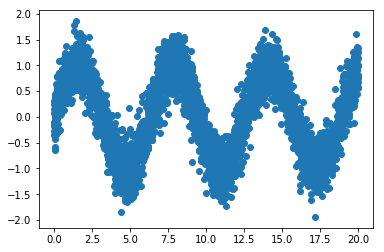

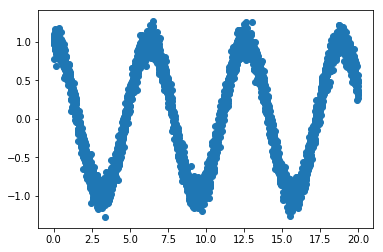

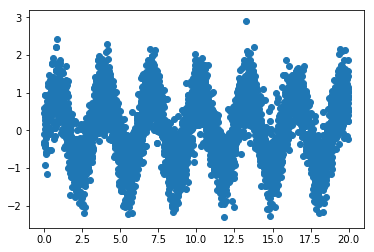

In [53]:
for i in range(Y.shape[1]):
    plt.figure()
    plt.scatter(X, Y[:, i])
    plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [54]:
# Hyperparameters
lr = 0.001
lr_mdn = 0.001
batch_size = 128
epochs = 1000
patience = 20
modes = 1

No we implement the loss for mixture density network. We model our network output as a multimodal, multidimensional Gaussian distribution where n is number of modes. Thus:

$$P(\vec{y}|\vec{x}) = \sum_{i=0}^n \pi_i(\vec{x}) N(\vec{y}|\vec{x}, \mu_i (\vec{x}), \Sigma_i (\vec{x}))$$

where the sum of the weights should yielt one. With this we get the loss:

$$L(\mu_i (\vec{x}), \Sigma_i (\vec{x})) = -log(\sum_{i=0}^n \pi_i(\vec{x}) N(\vec{y}|\vec{x}, \mu_i (\vec{x}), \Sigma_i (\vec{x})))$$

To increase stability of the training we apply two tricks. We predict the log of the standard deviations (diagonal elements of covariances) as in the original paper:

$$\sigma = e^{z}$$

with z the output of the network. Further do we apply tf.LogSumExp to the above sum for more numerical stability.

In [1]:
def mdn_loss(y_true, y_pred):
    """
    Computes mdn loss
    
    args:
        y_true: labels plus dummy labels for std and weight 
        y_pred: prediction
        
    returns:
        loss
    """
    
    targets = y_true[:, :dims]
    means = y_pred[:, :modes*dims]
    std = tf.square(tf.exp(y_pred[:, modes*dims:2*modes*dims]))
    weights = y_pred[:, 2*modes*dims:2*modes*dims + modes]
    
    
    modes_prob = []
    for i in range(modes):
        log_prob = 0
        for j in range(dims):
            diff = tf.subtract(targets[:, j:(j+1)], means[:, i+j:(i+j+1)])
            log_prob += -1*tf.divide(tf.square(diff), 2*std[:, i+j:(i+j+1)]) - tf.log(tf.sqrt(2*np.pi*std[:, i+j:(i+j+1)]))
        log_prob += tf.log(weights[:, i:(i+1)])
        modes_prob.append(log_prob)
        
    prob = tf.concat(modes_prob, axis=1)
    
    loss = tf.reduce_logsumexp(prob, axis=1)
    loss = tf.reduce_mean(loss, axis=0)
    
    return (-1)*loss

In [56]:
def get_model(mdn=False, dims=2):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(100, activation='relu')(dense)
    dense = Dense(100, activation='relu')(dense)
    
    if not mdn:
        out = Dense(dims)(dense)
    else:
        out_mean = Dense(dims*modes)(dense)
        
        out_std = Dense(dims*modes)(dense)
#         out_std = Lambda(lambda x: tf.abs(x))(out_std)
        
        
        out_weights = Dense(modes, activation='softmax')(dense)
#         out_weights = Lambda(lambda x: tf.abs(x)/(tf.reduce_sum(tf.abs(x))+1e-12))(out_weights)
        
        out = Concatenate(axis=1)([out_mean, out_std, out_weights])
    
    model = Model(inputs=[inp], outputs=[out])
    
    if not mdn:
        model.compile(Adam(lr=lr), loss='mse')
    else:
        model.compile(Adam(lr=lr_mdn), loss=mdn_loss)
    
    return model

Fit normal dense model to data

In [57]:
model = get_model(mdn=False, dims=dims)

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_29 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 303       
Total params: 20,703
Trainable params: 20,703
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit(
    x = X,
    y = Y,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 109us/step - loss: 0.6563 - val_loss: 0.6275
Epoch 2/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.6131 - val_loss: 0.6168
Epoch 3/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.5948 - val_loss: 0.5929
Epoch 4/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.5862 - val_loss: 0.5840
Epoch 5/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.5712 - val_loss: 0.5739
Epoch 6/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.5660 - val_loss: 0.5659
Epoch 7/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.5592 - val_loss: 0.5638
Epoch 8/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.5565 - val_loss: 0.5616
Epoch 9/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.5506 - val_loss: 0.5536
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.3273 - val_loss: 0.3431
Epoch 79/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.3288 - val_loss: 0.3474
Epoch 80/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.3262 - val_loss: 0.3418
Epoch 81/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.3195 - val_loss: 0.3207
Epoch 82/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.3168 - val_loss: 0.3224
Epoch 83/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.3078 - val_loss: 0.3177
Epoch 84/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.3056 - val_loss: 0.3215
Epoch 85/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.3026 - val_loss: 0.3095
Epoch 86/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.2970 - val_loss: 0.3058
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.1758 - val_loss: 0.1948
Epoch 156/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1745 - val_loss: 0.1932
Epoch 157/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1770 - val_loss: 0.1879
Epoch 158/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.1744 - val_loss: 0.1889
Epoch 159/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.1777 - val_loss: 0.1892
Epoch 160/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1729 - val_loss: 0.1862
Epoch 161/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1723 - val_loss: 0.1843
Epoch 162/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.1793 - val_loss: 0.1895
Epoch 163/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1800 - val_loss: 0.1887
Epoch 164/1000
4000/4000 [===========

4000/4000 [==============================] - 0s 16us/step - loss: 0.1449 - val_loss: 0.1559
Epoch 232/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1504 - val_loss: 0.1645
Epoch 233/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1415 - val_loss: 0.1607
Epoch 234/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.1446 - val_loss: 0.1547
Epoch 235/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1437 - val_loss: 0.1568
Epoch 236/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1408 - val_loss: 0.1500
Epoch 237/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1411 - val_loss: 0.1547
Epoch 238/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1404 - val_loss: 0.1529
Epoch 239/1000
4000/4000 [==============================] - 0s 20us/step - loss: 0.1416 - val_loss: 0.1504
Epoch 240/1000
4000/4000 [==========================

4000/4000 [==============================] - 0s 15us/step - loss: 0.1295 - val_loss: 0.1330
Epoch 308/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1322 - val_loss: 0.1379
Epoch 309/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1267 - val_loss: 0.1341
Epoch 310/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1283 - val_loss: 0.1358
Epoch 311/1000
4000/4000 [==============================] - 0s 16us/step - loss: 0.1260 - val_loss: 0.1375
Epoch 312/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1273 - val_loss: 0.1409
Epoch 313/1000
4000/4000 [==============================] - 0s 18us/step - loss: 0.1270 - val_loss: 0.1363
Epoch 314/1000
4000/4000 [==============================] - 0s 17us/step - loss: 0.1262 - val_loss: 0.1457
Epoch 315/1000
4000/4000 [==============================] - 0s 15us/step - loss: 0.1331 - val_loss: 0.1451
Epoch 316/1000
4000/4000 [==========================

Visualize prediction

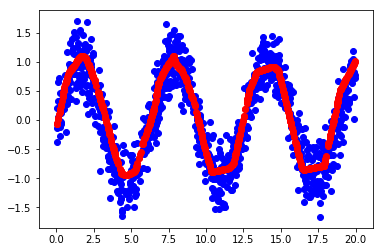

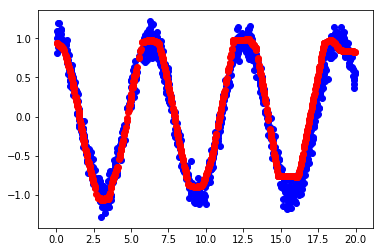

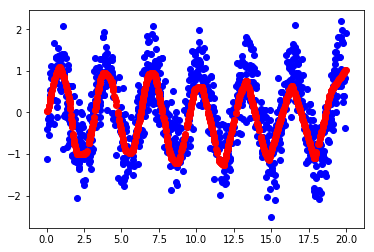

In [60]:
preds = model.predict(X_val)

for i in range(Y.shape[1]):
    plt.figure()
    plt.scatter(X_val, Y_val[:, i], color='b')
    plt.scatter(X_val, preds[:, i], color='r')
    plt.show()

Fit mixture density network to model

In [63]:
model_mdn = get_model(mdn=True, dims=dims)

In [64]:
model_mdn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 100)          200         input_8[0][0]                    
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 100)          10100       dense_37[0][0]                   
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 100)          10100       dense_38[0][0]                   
__________________________________________________________________________________________________
dense_40 (

In [65]:
Y_mdn = np.concatenate([np.reshape(Y, (Y.shape[0], dims)), np.zeros((Y.shape[0], modes*3-dims))], axis=1)
Y_mdn_val = np.concatenate([np.reshape(Y_val, (Y_val.shape[0], dims)), np.zeros((Y_val.shape[0], modes*3-dims))], axis=1)

model_mdn.fit(
    x = X,
    y = Y_mdn,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_mdn_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 189us/step - loss: 4.7748 - val_loss: 3.5974
Epoch 2/1000
4000/4000 [==============================] - 0s 29us/step - loss: 3.5702 - val_loss: 3.5574
Epoch 3/1000
4000/4000 [==============================] - 0s 28us/step - loss: 3.5197 - val_loss: 3.5166
Epoch 4/1000
4000/4000 [==============================] - 0s 34us/step - loss: 3.4617 - val_loss: 3.4389
Epoch 5/1000
4000/4000 [==============================] - 0s 32us/step - loss: 3.3784 - val_loss: 3.3216
Epoch 6/1000
4000/4000 [==============================] - 0s 28us/step - loss: 3.2628 - val_loss: 3.2165
Epoch 7/1000
4000/4000 [==============================] - 0s 28us/step - loss: 3.1748 - val_loss: 3.1706
Epoch 8/1000
4000/4000 [==============================] - 0s 30us/step - loss: 3.1348 - val_loss: 3.1253
Epoch 9/1000
4000/4000 [==============================] - 0s 38us/step - loss: 3.0841 - val_loss: 3.0656
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 30us/step - loss: 2.1241 - val_loss: 2.1832
Epoch 79/1000
4000/4000 [==============================] - 0s 27us/step - loss: 2.1070 - val_loss: 2.1602
Epoch 80/1000
4000/4000 [==============================] - 0s 26us/step - loss: 2.0999 - val_loss: 2.1161
Epoch 81/1000
4000/4000 [==============================] - 0s 26us/step - loss: 2.1119 - val_loss: 2.1145
Epoch 82/1000
4000/4000 [==============================] - 0s 31us/step - loss: 2.0843 - val_loss: 2.1034
Epoch 83/1000
4000/4000 [==============================] - 0s 30us/step - loss: 2.0543 - val_loss: 2.2205
Epoch 84/1000
4000/4000 [==============================] - 0s 28us/step - loss: 2.1013 - val_loss: 2.1582
Epoch 85/1000
4000/4000 [==============================] - 0s 27us/step - loss: 2.0975 - val_loss: 2.0825
Epoch 86/1000
4000/4000 [==============================] - 0s 27us/step - loss: 2.0433 - val_loss: 2.1309
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 29us/step - loss: 1.5971 - val_loss: 1.6403
Epoch 156/1000
4000/4000 [==============================] - 0s 27us/step - loss: 1.5508 - val_loss: 1.6126
Epoch 157/1000
4000/4000 [==============================] - 0s 27us/step - loss: 1.5402 - val_loss: 1.5518
Epoch 158/1000
4000/4000 [==============================] - 0s 27us/step - loss: 1.5155 - val_loss: 1.5616
Epoch 159/1000
4000/4000 [==============================] - 0s 29us/step - loss: 1.5455 - val_loss: 1.5246
Epoch 160/1000
4000/4000 [==============================] - 0s 29us/step - loss: 1.4988 - val_loss: 1.5888
Epoch 161/1000
4000/4000 [==============================] - 0s 28us/step - loss: 1.5032 - val_loss: 1.5860
Epoch 162/1000
4000/4000 [==============================] - 0s 28us/step - loss: 1.5292 - val_loss: 1.5557
Epoch 163/1000
4000/4000 [==============================] - 0s 27us/step - loss: 1.5592 - val_loss: 1.6870
Epoch 164/1000
4000/4000 [===========

4000/4000 [==============================] - 0s 30us/step - loss: 0.9040 - val_loss: 0.9391
Epoch 232/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.9130 - val_loss: 0.9371
Epoch 233/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.9070 - val_loss: 0.9859
Epoch 234/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.9157 - val_loss: 1.0163
Epoch 235/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.9091 - val_loss: 0.9356
Epoch 236/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.8637 - val_loss: 0.8265
Epoch 237/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.8770 - val_loss: 0.8731
Epoch 238/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.8556 - val_loss: 0.8152
Epoch 239/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.8985 - val_loss: 0.8615
Epoch 240/1000
4000/4000 [==========================

4000/4000 [==============================] - 0s 27us/step - loss: 0.5898 - val_loss: 0.5742
Epoch 308/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.5273 - val_loss: 0.5411
Epoch 309/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4479 - val_loss: 0.6075
Epoch 310/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.4095 - val_loss: 0.6011
Epoch 311/1000
4000/4000 [==============================] - 0s 28us/step - loss: 0.4634 - val_loss: 0.5025
Epoch 312/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.4508 - val_loss: 0.4870
Epoch 313/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.3977 - val_loss: 0.5062
Epoch 314/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.4424 - val_loss: 0.5011
Epoch 315/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.4169 - val_loss: 0.4653
Epoch 316/1000
4000/4000 [==========================

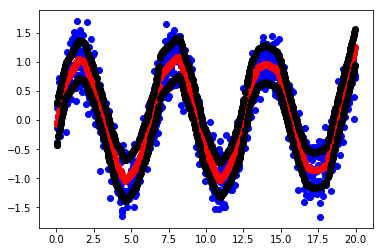

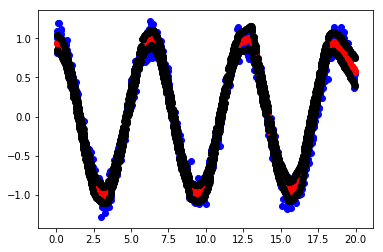

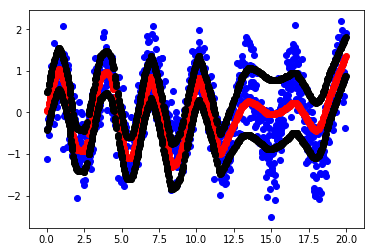

In [67]:
preds_mdn = model_mdn.predict(X_val)

preds_mdn_means = preds_mdn[:, :dims*modes]
preds_mdn_stds = preds_mdn[:, dims*modes:2*dims*modes]
preds_mdn_weights = preds_mdn[:, 2*dims*modes:2*dims*modes + modes]

preds_mdn_final = np.einsum('ijk,ik->ij',np.reshape(preds_mdn_means, (preds_mdn_means.shape[0], dims, modes)), 
                            preds_mdn_weights)
std_mdn_final = np.exp(np.einsum('ijk,ik->ij',np.reshape(preds_mdn_stds, (preds_mdn_stds.shape[0], dims, modes)), 
                            preds_mdn_weights))

for i in range(dims):
    plt.figure()
    plt.scatter(X_val, Y_val[:, i], color='b')
    plt.scatter(X_val, preds_mdn_final[:, i], color='r')
    plt.scatter(X_val, preds_mdn_final[:, i] + std_mdn_final[:, i], color='k')
    plt.scatter(X_val, preds_mdn_final[:, i] - std_mdn_final[:, i], color='k')
    plt.show()

In [68]:
print('Mean Sigmas:')
print(np.exp(preds_mdn_stds.mean(axis=0)))
print('Mean Weights:')
print(preds_mdn_weights.mean(axis=0))

Mean Sigmas:
[0.31798616 0.11276491 0.57251877]
Mean Weights:
[1.]


# Error comparison

Comparing the errors of normal model vs. mdn

In [70]:
error = np.mean(np.abs(preds - Y_val))
error_mdn = np.mean(np.abs(preds_mdn_final - Y_val))

print('Error normal: ' + str(error))
print('Error MDN: ' + str(error_mdn))

Error normal: 0.2856436731532756
Error MDN: 0.2855486531576272


# Visualize uncertainty estimate

Variance depending on prediction error

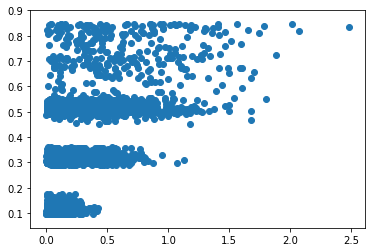

In [71]:
plt.figure()
plt.scatter(np.abs(preds_mdn_final - Y_val), std_mdn_final)
plt.show()